In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from bloch.bloch import bloch
import os.path

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [22]:
# Excitation pulse calculation
pf_exc = 'pulses/hsinc_400_8750.hsinc_400_8750.pta'
EXC_AMP_INT = 45.4907  # Manualy coppied from file
pulse_dur_exc = 3.2

pulse_df = pd.read_csv(
    pf_exc,
    sep=r"\s+",
    index_col=False,
    skip_blank_lines=True,
    names=['Amplitude', 'Phase'],
    skiprows=8)

amp_int_rel = EXC_AMP_INT / pulse_df['Amplitude'].size
fa = 90
pulse_length_exc = pulse_dur_exc / 1E3  # In s.
pulse_amp_hz = 500 * (1E-3/pulse_length_exc) * (fa/180) * (1/amp_int_rel)
exc_pulse_hz = pulse_df['Amplitude'].to_numpy()\
    * np.exp(1j * pulse_df['Phase'].to_numpy())
exc_pulse_hz *= pulse_amp_hz
print(pulse_amp_hz)

686.9535971088598


/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gp/T/ipykernel_94784/762957570.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  pulse_df = pd.read_csv(


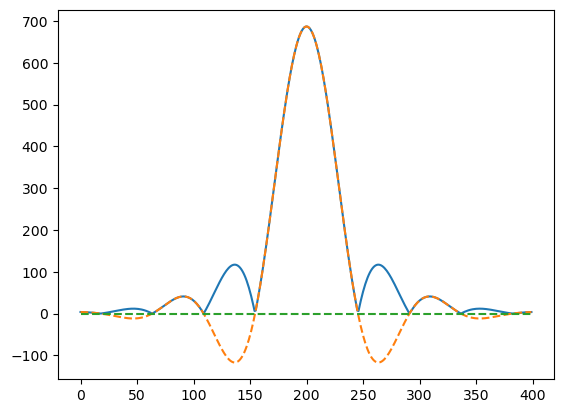

In [23]:
plt.plot(np.abs(exc_pulse_hz))
plt.plot(exc_pulse_hz.real,'--')
plt.plot(exc_pulse_hz.imag,'--')

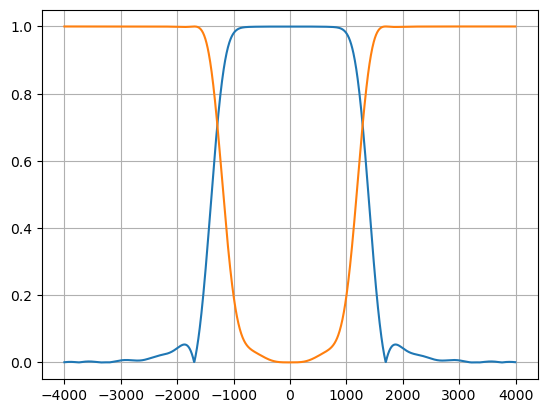

In [24]:
g = np.zeros(exc_pulse_hz.shape)

dt = (pulse_dur_exc / 1E3) / exc_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(exc_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.grid()
plt.show()

## Refocussing pulse

1875.0


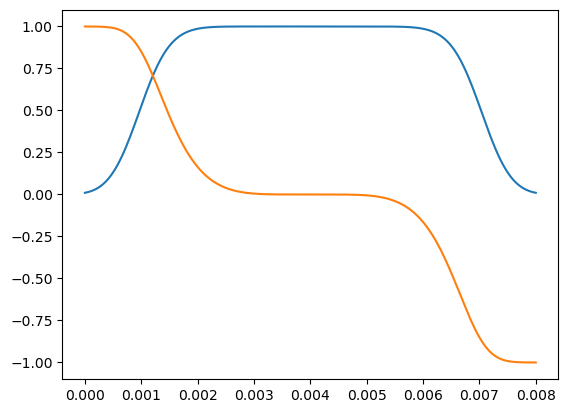

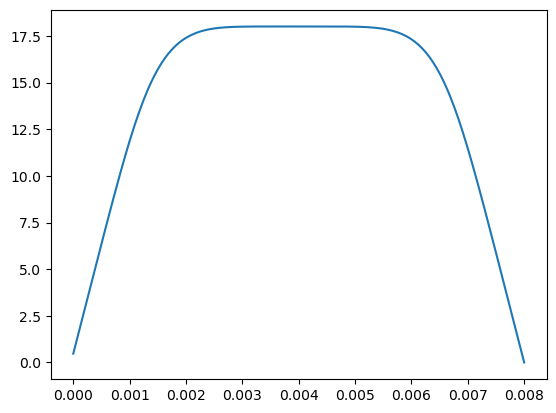

In [9]:
# Hyperbolicsecant
pulse_dur_ref = 8 * 1E-3
ref_points = 200
taxis = np.linspace(0,pulse_dur_ref,ref_points)

beta = np.arccosh(100)
N = 5
r = 30
bw = r/(pulse_dur_ref*2)
print(bw)
amp = 1 / np.cosh(beta * (1-(2*taxis/pulse_dur_ref))**N)
fm = bw * np.tanh(beta * (1-(2*taxis/pulse_dur_ref))**N)
pm = 2 * np.pi * np.cumsum(fm) * taxis[1]
plt.plot(taxis,amp)
plt.plot(taxis,fm/bw)
plt.show()
plt.plot(taxis,pm)

ref_pulse_cmplx = amp * np.exp(1j*pm)

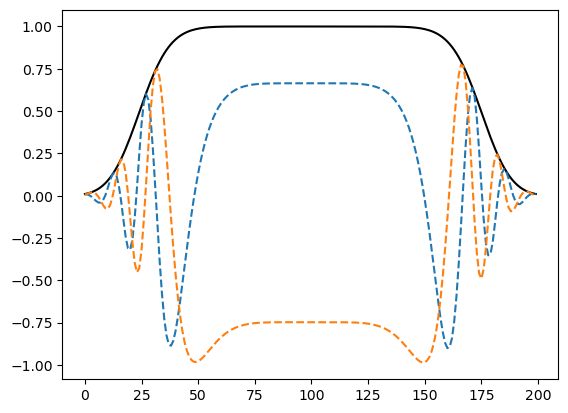

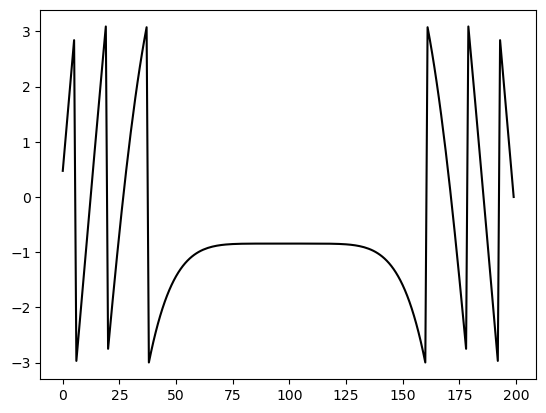

In [10]:
plt.plot(np.abs(ref_pulse_cmplx),'k')
plt.plot(ref_pulse_cmplx.real,'--')
plt.plot(ref_pulse_cmplx.imag,'--')
plt.show()

plt.plot(np.angle(ref_pulse_cmplx),'k')
plt.show()

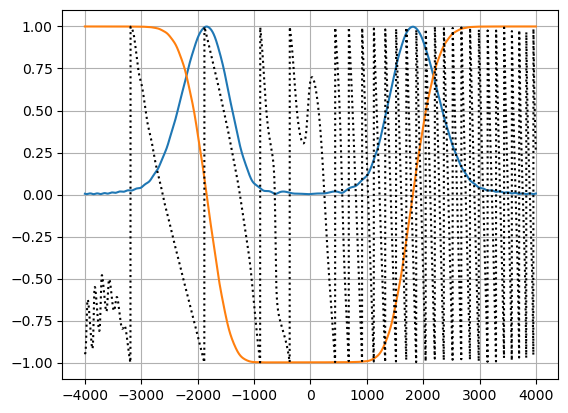

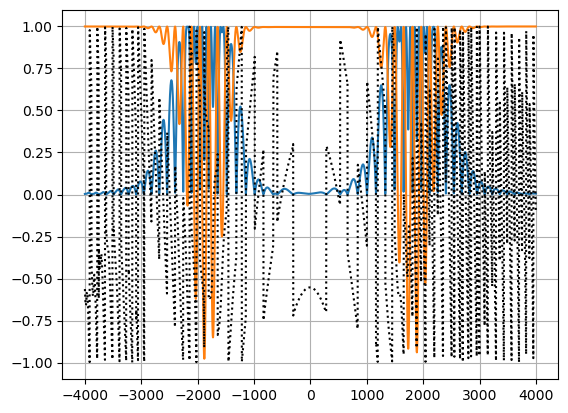

In [12]:
ref_pulse_hz = ref_pulse_cmplx * 500*2.84

g = np.zeros(ref_pulse_hz.shape)

dt = (pulse_dur_ref) / ref_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-4000,4000,2, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(ref_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.plot(df,np.angle(mx+1j*my)/np.pi,'k:')
plt.grid()
plt.show()

mx, my, mz = bloch(ref_pulse_hz, g, dt, t1, t2, df, dp, mode, mx, my, mz)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.plot(df,np.angle(mx+1j*my)/np.pi,'k:')
plt.grid()
plt.show()

In [28]:
# Adiabatic limit
B1_hz_vec = np.arange(100,5000,100)
df = np.arange(-6000,6000,20, dtype=float)

dur_vec = [5,6,7,8,9]
mxy_store_dur = []
mz_store_dur = []
for dur in dur_vec :
    dt2 = (dur / 1E3) / ref_pulse_hz.size
    mxy_store = []
    mz_store = []
    for b1 in B1_hz_vec:
        ref_pulse_hz = ref_pulse_cmplx * b1
        mx, my, mz = bloch(ref_pulse_hz, g, dt2, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)
        mxy_store.append(np.abs(mx+1j*my))
        mz_store.append(mz)

    mxy_store_dur.append(np.concatenate(mxy_store,axis=1))
    mz_store_dur.append(np.concatenate(mz_store,axis=1))

mxy_store_dur = np.asarray(mxy_store_dur)
mz_store_dur = np.asarray(mz_store_dur)

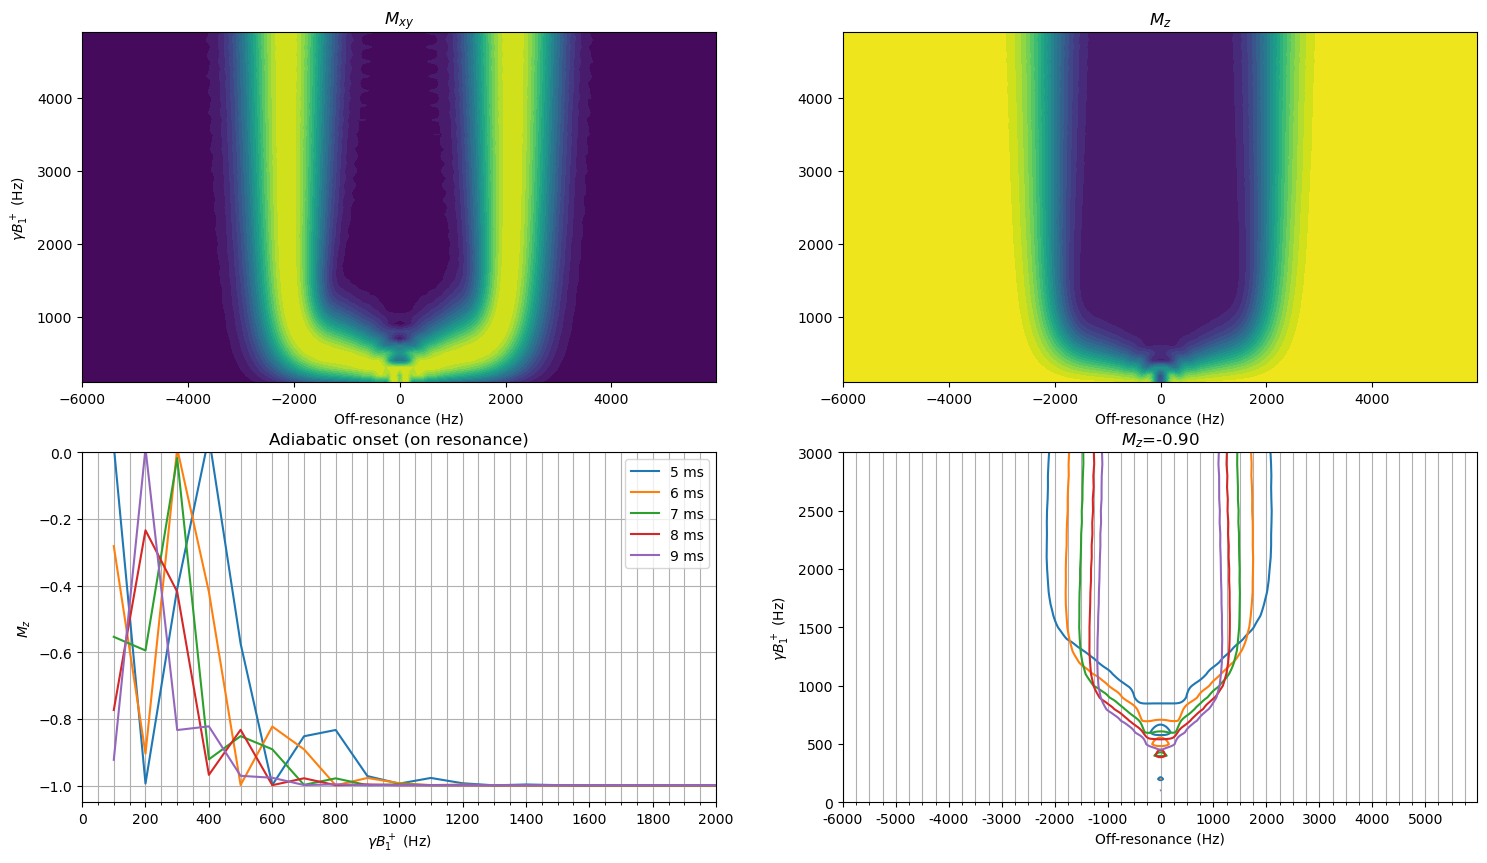

In [29]:
fig, ax = plt.subplots(2,2,figsize=(18,10),sharey=False)
ax[0][0].contourf(df,B1_hz_vec,mxy_store_dur[2].T, levels= np.arange(0,1.1,0.05))
ax[0][1].contourf(df,B1_hz_vec,mz_store_dur[2].T, levels= np.arange(-1.1,1.1,0.10))

lineObjects = ax[1][0].plot(B1_hz_vec, mz_store_dur[:,int(df.size/2),:].squeeze().T)
ax[1][0].legend(lineObjects, [f'{x} ms' for x in dur_vec])

for mz, lo in zip(mz_store_dur, lineObjects):
    ax[1][1].contour(df,B1_hz_vec,mz.T, levels=(-0.90,), colors=lo.get_color(), linestyles='solid')


ax[0][0].set_ylabel('$\gamma B_1^+$ (Hz)')
ax[0][0].set_xlabel('Off-resonance (Hz)')
ax[0][1].set_xlabel('Off-resonance (Hz)')
ax[0][0].set_title('$M_{xy}$')
ax[0][1].set_title('$M_{z}$')

ax[1][0].set_xlim([0, 2000])
ax[1][0].set_ylim([-1.05, 0])
ax[1][0].set_xlabel('$\gamma B_1^+$ (Hz)')
ax[1][0].set_ylabel('$M_{z}$')

ax[1][0].xaxis.set_major_locator(MultipleLocator(200))
ax[1][0].xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax[1][0].xaxis.set_minor_locator(MultipleLocator(50))
ax[1][0].grid(which='both')

ax[1][1].set_ylim([0, 3000])
ax[1][1].xaxis.set_major_locator(MultipleLocator(1000))
ax[1][1].xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax[1][1].xaxis.set_minor_locator(MultipleLocator(250))
ax[1][1].grid(which='both',axis='x')
ax[1][1].set_ylabel('$\gamma B_1^+$ (Hz)')
ax[1][1].set_xlabel('Off-resonance (Hz)')
ax[1][0].set_title('Adiabatic onset (on resonance)')
ax[1][1].set_title('$M_{z}$=-0.90')
plt.show()